# Identifiability test

In this notebook, we reproduce the analyses underlying **Extended Data Figure 9** , which demonstrate that the two Bayesian observer models considered in the paper are **identifiable**.

The goal of the identifiability test is to verify that data generated from one model (scalar variability vs. subscalar variability) are preferentially better explained by the same model when both candidate models are fit to the data. This provides evidence that the models make distinguishable predictions at the behavioral level.

### Overview of the simulation procedure

Each identifiability simulation consists of three main steps:

1. **Synthetic data generation**  
   Behavioral data are generated from a *ground-truth Bayesian observer model*. For each trial, a true temporal distance \( t_s \) is corrupted by measurement noise, transformed into a Bayesian least-squares estimate via the posterior mean, and finally corrupted by production noise to yield a produced interval \( t_p \).  
   Two alternative generative models are considered:
   - a **scalar variability model**, in which noise scales linearly with time;
   - a **subscalar variability (reset / counting) model**, in which noise scales with the square root of time.

2. **Model fitting**  
   The same synthetic dataset is then fit using **both** Bayesian models via maximum likelihood estimation. Each model estimates its own measurement noise, production noise, and offset parameters.

3. **Model comparison**  
   Model performance is evaluated using:
   - the negative log-likelihood (and derived BIC),
   - an MSE-like metric that jointly captures bias and variance, matching the procedure used in the original MATLAB implementation.


### Computational constraints

Running the identifiability analysis is computationally expensive because each simulation requires:
- generating a full synthetic dataset,
- fitting two nonlinear Bayesian models via numerical integration and optimization,
- simulating additional datasets from the fitted models to compute bias–variance metrics.

For this reason, we run **10 simulations per generative model**, compared with approximately **100 simulations** in the original paper. Each simulation contains **500 trials**, matching the structure of the behavioral data but at reduced scale.

Although this reduced number of simulations limits statistical power, it is sufficient to qualitatively reproduce the key identifiability patterns reported in the paper.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

df_1 = pd.read_csv("counting_sim_1.csv")  
df_2 = pd.read_csv('counting_sim_2.csv')

df_counting = pd.concat([df_1, df_2], ignore_index=True)

print(df_counting.head())
print(df_counting["fitted_model"].value_counts())


   sim_id generator_model fitted_model  wm_true  wp_true  offset_true  \
0       0        counting     counting     0.15      0.2         0.01   
1       0        counting       timing     0.15      0.2         0.01   
2       1        counting     counting     0.15      0.2         0.01   
3       1        counting       timing     0.15      0.2         0.01   
4       2        counting     counting     0.15      0.2         0.01   

     wm_hat    wp_hat  offset_hat   negloglik         bic  mse_bias_var  \
0  0.130291  0.194165   -0.011276   88.516428  195.676679      0.024021   
1  0.111972  0.158690    0.005334  115.370756  249.385337      0.193619   
2  0.159837  0.186773    0.018448   99.788479  218.220782      0.034036   
3  0.134048  0.153666    0.027724  129.195192  277.034208      0.266137   
4  0.138963  0.207707    0.002562  119.947721  258.539266      0.032715   

   n_trials  success         fun  
0       500     True   88.516428  
1       500     True  115.370756  
2    

In [5]:
df_3= pd.read_csv('timing_sim_1.csv')
df_4= pd.read_csv('timing_sim_2.csv')

df_timing= pd.concat([df_3,df_4],ignore_index= True)

df_timing.head()

,sim_id,generator_model,fitted_model,wm_true,wp_true,offset_true,wm_hat,wp_hat,offset_hat,negloglik,bic,mse_bias_var,n_trials,success,fun
0,0,timing,counting,0.15,0.2,0.01,0.161194,0.276865,-0.027897,253.094852,524.833528,0.121914,500,True,253.094852
1,0,timing,timing,0.15,0.2,0.01,0.135264,0.193786,-0.008992,217.460511,453.564845,0.104971,500,True,217.460511
2,1,timing,counting,0.15,0.2,0.01,0.200745,0.266222,0.002175,261.347768,541.339359,0.255059,500,True,261.347768
3,1,timing,timing,0.15,0.2,0.01,0.158733,0.186982,0.012181,228.787186,476.218197,0.039358,500,True,228.787186
4,2,timing,counting,0.15,0.2,0.01,0.154987,0.294757,0.002274,275.157770,568.959363,0.164753,500,True,275.157770


Notice that in this notation: 
- Counting: model **with reset**, subscalar variability 
- Timing: model **without reset**, scalar variability 


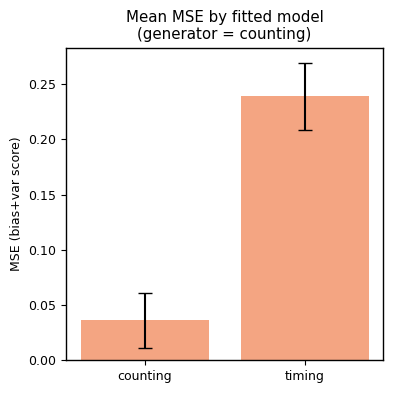

In [32]:
group = df_counting.groupby("fitted_model")["mse_bias_var"]
means = group.mean()
stds = group.std()

plt.figure(figsize=(4, 4))
x = range(len(means))

plt.bar(x,means,color="#f4a582", yerr=stds, capsize=5)
plt.xticks(x, means.index)
plt.ylabel("MSE (bias+var score)")
plt.title("Mean MSE by fitted model\n(generator = counting)")
plt.tight_layout()
plt.show()


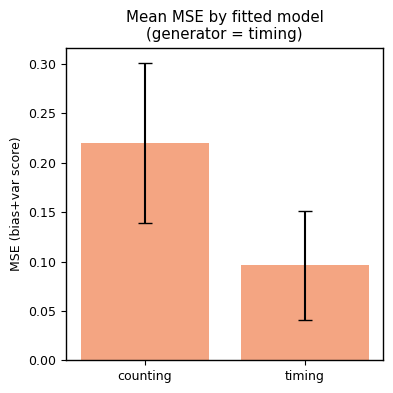

In [33]:
group = df_timing.groupby("fitted_model")["mse_bias_var"]
means = group.mean()
stds = group.std()

plt.figure(figsize=(4, 4))
x = range(len(means))

plt.bar(x, means,color="#f4a582", yerr=stds, capsize=5)
plt.xticks(x, means.index)
plt.ylabel("MSE (bias+var score)")
plt.title("Mean MSE by fitted model\n(generator = timing)")
plt.tight_layout()
plt.show()


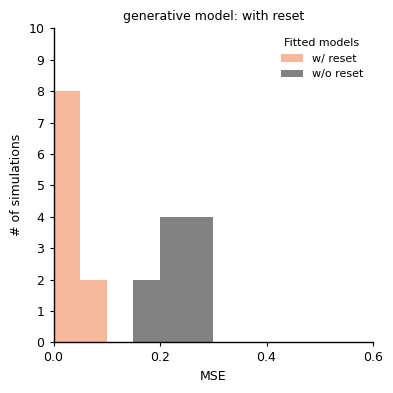

In [ ]:
gen_label_map = {
    "counting": "generative model: with reset",
    "timing": "generative model: without reset",
}


plt.figure(figsize=(4, 4))  

# Split by fitted model
fit_names = df_counting["fitted_model"].unique()
sub1 = df_counting[df_counting["fitted_model"] == fit_names[0]]   # e.g. w/ reset
sub2 = df_counting[df_counting["fitted_model"] == fit_names[1]]   # e.g. w/o reset


plt.rcParams["font.size"] = 9
plt.rcParams["axes.linewidth"] = 1.0

ax = plt.gca()

gen_model = df_counting["generator_model"].iloc[0]
title_text = gen_label_map[gen_model]

ax.set_title(title_text, fontsize=9, pad=6)


# Use identical bins for both histograms
bins = np.linspace(0, 0.6, 13)   # 0.0 ... 0.6 in small steps

ax.hist(sub1["mse_bias_var"], bins=bins,
        color="#f4a582", alpha=0.8, label="w/ reset")
ax.hist(sub2["mse_bias_var"], bins=bins,
        color="#636363", alpha=0.8, label="w/o reset")

#axes limits & ticks
ax.set_xlim(0, 0.6)
ax.set_xticks([0.0, 0.2, 0.4, 0.6])
ax.set_xticklabels(["0.0", "0.2", "0.4", "0.6"])

ax.set_ylim(0, 10)               
ax.set_yticks([0, 1, 2, 3, 4,5,6,7,8,9,10])

ax.set_xlabel("MSE")
ax.set_ylabel("# of simulations")

# legend inside the axes
leg = ax.legend(title="Fitted models", frameon=False,
                loc="upper right", fontsize=8, title_fontsize=8)

# remove top/right spines 
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(direction="out", length=3, width=0.8)

plt.tight_layout()
plt.show()


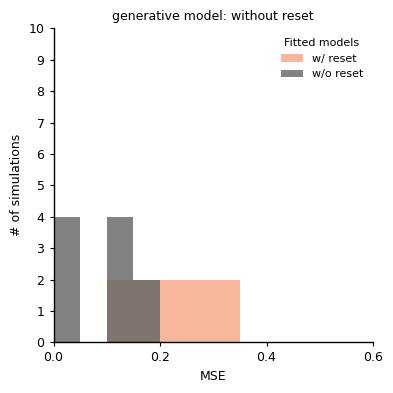

In [17]:

plt.figure(figsize=(4, 4))  

# Split by fitted model
fit_names = df_timing["fitted_model"].unique()
sub1 = df_timing[df_timing["fitted_model"] == fit_names[0]]   # e.g. w/ reset
sub2 = df_timing[df_timing["fitted_model"] == fit_names[1]]   # e.g. w/o reset


plt.rcParams["font.size"] = 9
plt.rcParams["axes.linewidth"] = 1.0

ax = plt.gca()

gen_model = df_timing["generator_model"].iloc[0]
title_text = gen_label_map[gen_model]

ax.set_title(title_text, fontsize=9, pad=6)


# Use identical bins for both histograms
bins = np.linspace(0, 0.6, 13)   # 0.0 ... 0.6 in small steps

ax.hist(sub1["mse_bias_var"], bins=bins,
        color="#f4a582", alpha=0.8, label="w/ reset")
ax.hist(sub2["mse_bias_var"], bins=bins,
        color="#636363", alpha=0.8, label="w/o reset")

#axes limits & ticks
ax.set_xlim(0, 0.6)
ax.set_xticks([0.0, 0.2, 0.4, 0.6])
ax.set_xticklabels(["0.0", "0.2", "0.4", "0.6"])

ax.set_ylim(0, 10)               
ax.set_yticks([0, 1, 2, 3, 4,5,6,7,8,9,10])

ax.set_xlabel("MSE")
ax.set_ylabel("# of simulations")

# legend inside the axes
leg = ax.legend(title="Fitted models", frameon=False,
                loc="upper right", fontsize=8, title_fontsize=8)

# remove top/right spines 
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(direction="out", length=3, width=0.8)

plt.tight_layout()
plt.show()


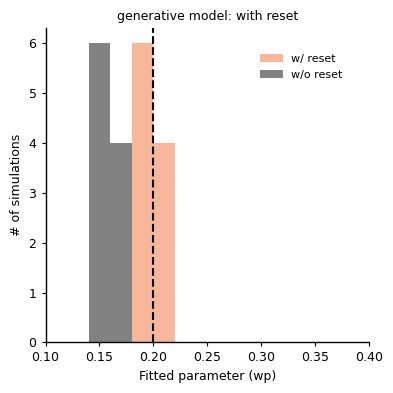

In [26]:
wp_true = 0.20

# Single panel figure
plt.figure(figsize=(4, 4))   # square, paper-like
plt.rcParams["font.size"] = 9

# Colors and labels
color_map = {
    "counting": "#f4a582",   # w/ reset
    "timing":   "#636363",   # w/o reset
}

label_map = {
    "counting": "w/ reset",
    "timing":   "w/o reset",
}

# Bins and limits (same as before)
bins = np.linspace(0.1, 0.4, 16)
xlim = (0.1, 0.4)

ax = plt.gca()

# Select ONLY counting-generated data
df_gen = df_counting[df_counting["generator_model"] == "counting"]

# Plot fitted models
for fit_name, subdf in df_gen.groupby("fitted_model"):
    ax.hist(
        subdf["wp_hat"],
        bins=bins,
        alpha=0.8,
        color=color_map[fit_name],
        label=label_map[fit_name]
    )

# True parameter
ax.axvline(wp_true, color="k", linestyle="--")

# Labels and title
ax.set_xlim(*xlim)
ax.set_xlabel("Fitted parameter (wp)")
ax.set_ylabel("# of simulations")
ax.set_title("generative model: with reset", fontsize=9, pad=6)

# Legend (upper-left, nudged to avoid overlap)
ax.legend(
    frameon=False,
    fontsize=8,
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95)
)

# Clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out", length=3, width=0.8)

plt.tight_layout()
plt.show()


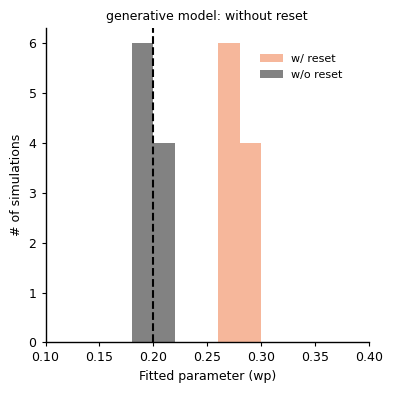

In [29]:
wp_true = 0.20

# Single panel figure
plt.figure(figsize=(4, 4))   # square, paper-like
plt.rcParams["font.size"] = 9

# Colors and labels
color_map = {
    "counting": "#f4a582",   # w/ reset
    "timing":   "#636363",   # w/o reset
}

label_map = {
    "counting": "w/ reset",
    "timing":   "w/o reset",
}

# Bins and limits (same as before)
bins = np.linspace(0.1, 0.4, 16)
xlim = (0.1, 0.4)

ax = plt.gca()

# Select ONLY timing-generated data
df_gen = df_timing[df_timing["generator_model"] == "timing"]

# Plot fitted models
for fit_name, subdf in df_gen.groupby("fitted_model"):
    ax.hist(
        subdf["wp_hat"],
        bins=bins,
        alpha=0.8,
        color=color_map[fit_name],
        label=label_map[fit_name]
    )

# True parameter
ax.axvline(wp_true, color="k", linestyle="--")

# Labels and title
ax.set_xlim(*xlim)
ax.set_xlabel("Fitted parameter (wp)")
ax.set_ylabel("# of simulations")
ax.set_title("generative model: without reset", fontsize=9, pad=6)

# Legend (upper-left, nudged to avoid overlap)
ax.legend(
    frameon=False,
    fontsize=8,
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95)
)

# Clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out", length=3, width=0.8)

plt.tight_layout()
plt.show()
